# Predicting Transcription Factor Binding from DNA Sequences with CNNs

In this notebook, I build a deep learning pipeline to predict transcription factor (TF) binding sites from genomic DNA sequences. Starting from raw ChIP-seq peak data downloaded from the ENCODE project, I extract positive and negative sequence examples from the human genome (hg38). These sequences are one-hot encoded and used to train a convolutional neural network (CNN) implemented in PyTorch.

## 1. Setup and Imports

In [217]:
# --- Imports and seeding ---
import requests
import gzip
import os
import random
from pyfaidx import Fasta
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 2. Data Download and Preparation

Downloads a BED file from ENCODE containing transcription factor (TF) peak regions. 

In [218]:
# --- Download BED file from ENCODE ---
bed_url = "https://www.encodeproject.org/files/ENCFF881ONC/@@download/ENCFF881ONC.bed.gz"
bed_path = "tf_peaks.bed.gz"
if not os.path.exists(bed_path):
    r = requests.get(bed_url)
    with open(bed_path, "wb") as f:
        f.write(r.content)

Load TF peak regions. 

In [219]:
# --- Extract BED file ---
with gzip.open(bed_path, 'rt') as f:
    peaks = pd.read_csv(f, sep='\t', header=None, usecols=[0,1,2], names=['chr','start','end'])

Maps BED chromosome names to sequence IDs.

In [220]:
# --- Map chromosomes to sequence IDs ---
chrid = pd.DataFrame({'ID': [f'CM0006{x}.2' for x in list(range(63, 87))], 
                      'Chr': [f'chr{x}' for x in list(range(1,23)) + ['X', 'Y']]})

# Keep only peaks on valid chromosomes
peaks = peaks.loc[peaks.chr.isin(chrid.Chr),:].copy()

# Map chromosome names to genome IDs
peaks['ID'] = [chrid.loc[chrid['Chr'] == x,'ID'].iloc[0] for x in peaks['chr']]

## 3. Create Positive and Negative Examples

Import reference genome sequence. 

In [221]:
# --- Load genome sequence ---
genome = Fasta("hg38.fa")

Retrieves the DNA sequences corresponding to each TF peak (positive examples) and labels them as 1.

In [222]:
# --- Extract positive sequences ---
def get_seq(row):
    return str(genome[row['ID']][row['start']:row['end']].seq).upper()

peaks['sequence'] = peaks.apply(get_seq, axis=1)
peaks['label'] = 1

Generates negative examples by selecting random genomic regions of the same length as the peaks. Ensures negative sequences do not overlap any positive peak.

In [223]:
# --- Generate negative sequences ---
neg_seqs = []
for idx, row in peaks.iterrows():
    chr_len = len(genome[row['ID']])
    while True:
        start = random.randint(0, chr_len - (row['end']-row['start']))
        end = start + (row['end']-row['start'])
        if not ((peaks['start'] <= end) & (peaks['end'] >= start)).any():
            seq = str(genome[row['ID']][start:end].seq).upper()
            neg_seqs.append({'ID': row['ID'], 'start': start, 'end': end, 'sequence': seq, 'label': 0})
            break

neg_df = pd.DataFrame(neg_seqs)

Combines positive and negative sequences, shuffles them, and saves to a CSV for later input into the deep learning model.

In [224]:
# --- Combine positive and negative sequences ---
data = pd.concat([peaks, neg_df], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)  # shuffle

# --- Save sequences to CSV ---
data[['sequence','label']].to_csv("tf_sequences.csv", index=False)

print("Data ready:", data.shape)

Data ready: (51056, 6)


### 4. PyTorch Dataset and DataLoader

Defines a PyTorch Dataset class that:
* Converts DNA sequences to one-hot encoding.
* Optionally applies reverse-complement augmentation.
* Returns a sequence tensor and its label.

In [225]:
# --- Define PyTorch Dataset ---
class SeqDataset(Dataset):
    def __init__(self, df, max_len=200, augment=False):
        self.labels = df['label'].values.astype(np.float32)
        self.sequences = df['sequence'].tolist()
        self.max_len = max_len
        self.augment = augment

    def one_hot_encode(self, seq):
        mapping = {'A':0,'C':1,'G':2,'T':3}
        arr = np.zeros((4, self.max_len), dtype=np.float32)
        for i, base in enumerate(seq[:self.max_len]):
            if base in mapping:
                arr[mapping[base], i] = 1.0
        return arr

    # Reverse-complement DNA
    def revcomp(self, seq):
        complement = str.maketrans("ACGT", "TGCA")
        return seq.translate(complement)[::-1]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # Augment randomly with reverse complement
        if self.augment and np.random.rand() < 0.5:
            seq = self.revcomp(seq)
        x = torch.tensor(self.one_hot_encode(seq))
        y = torch.tensor(self.labels[idx])
        return x, y


## 5. Define CNN Model

Defines a simple 1D CNN for classifying sequences:
* Two convolution + pooling layers extract motif features.
* Fully connected layers perform classification.
* Dropout prevents overfitting.
* Sigmoid outputs probabilities.

In [226]:
# --- Define CNN Model ---
class CNN1D(nn.Module):
    def __init__(self, seq_len=200):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=10)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        conv_out_len = ((seq_len-9)//2 - 4) // 2  # after pooling twice
        self.fc1 = nn.Linear(64*conv_out_len, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x))


Splits data into training, validation, and test sets with stratification. Creates PyTorch DataLoaders. Training set uses augmentation.

In [227]:
# --- Split training, validation and test sets ---
df = pd.read_csv("tf_sequences.csv")
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=0)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=0)

train_ds = SeqDataset(train_df, augment = True)
val_ds   = SeqDataset(val_df, augment = True)
test_ds   = SeqDataset(test_df, augment = True)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader   = DataLoader(test_ds, batch_size=64)

## 6. Learning Rate Finder

Implements a learning rate finder: gradually increases LR while tracking loss. Suggests the LR where loss decreases most steeply.
Runs the LR finder and prints a suggested learning rate.

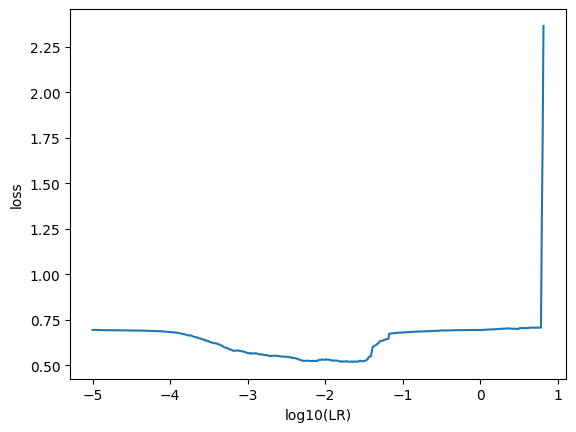

Suggested LR: 0.0003201668359362336


In [228]:
# --- Find best learning rate ---
def lr_find(model, train_loader, optimizer, criterion, device, 
            init_value=1e-5, final_value=10., beta=0.98):
    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss, best_loss = 0., float('inf')
    losses, log_lrs = [], []

    model.train()
    for batch_num, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)

        # smooth loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed = avg_loss / (1 - beta**(batch_num+1))

        # record
        losses.append(smoothed)
        log_lrs.append(np.log10(lr))

        # check diverging
        if batch_num > 1 and smoothed > 4*best_loss:
            break
        if smoothed < best_loss or batch_num==1:
            best_loss = smoothed

        # backward
        loss.backward()
        optimizer.step()

        # update lr
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    # plot
    plt.plot(log_lrs, losses)
    plt.xlabel("log10(LR)")
    plt.ylabel("loss")
    plt.show()
    return log_lrs, losses

def suggest_lr(log_lrs, losses):
    losses = np.array(losses)
    log_lrs = np.array(log_lrs)

    # compute gradients of loss wrt lr
    grads = np.gradient(losses, log_lrs)
    idx = np.argmin(grads)   # steepest descent
    best_log_lr = log_lrs[idx]
    return 10**best_log_lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(seq_len=200).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

log_lrs, losses = lr_find(model, train_loader, optimizer, criterion, device)
best_lr = suggest_lr(log_lrs, losses)
print("Suggested LR:", best_lr)

## 7. Early Stopping Implementation

Defines an early stopping mechanism that stops training if validation loss does not improve for a given number of epochs. Saves the best model state.

In [229]:
# --- Early Stopping Utility ---
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        """
        patience: number of epochs with no improvement after which training stops
        min_delta: minimum change in validation loss to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## 8. Training Loop with Early Stopping

Trains the CNN for up to 50 epochs with:
* Training and validation loss calculation.
* Validation accuracy computation.
* Early stopping based on validation loss.
* Stores the best model weights.

In [230]:
# --- Training Loop with Early Stopping ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D(seq_len=200).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1*best_lr)
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

for epoch in range(50):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

    print(f"Epoch {epoch+1}: Train loss {train_loss/len(train_loader):.4f}, "
          f"Val loss {val_loss/len(val_loader):.4f}, "
          f"Val acc {correct/total:.3f}")

    # Early stopping check
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break

model.load_state_dict(early_stopper.best_state)

Epoch 1: Train loss 0.5695, Val loss 0.5112, Val acc 0.747
Epoch 2: Train loss 0.5174, Val loss 0.5089, Val acc 0.753
Epoch 3: Train loss 0.5143, Val loss 0.5065, Val acc 0.752
Epoch 4: Train loss 0.5116, Val loss 0.5032, Val acc 0.757
Epoch 5: Train loss 0.5078, Val loss 0.4972, Val acc 0.757
Epoch 6: Train loss 0.5039, Val loss 0.4949, Val acc 0.757
Epoch 7: Train loss 0.5031, Val loss 0.4941, Val acc 0.761
Epoch 8: Train loss 0.4980, Val loss 0.4931, Val acc 0.759
Epoch 9: Train loss 0.4955, Val loss 0.4858, Val acc 0.766
Epoch 10: Train loss 0.4887, Val loss 0.4780, Val acc 0.770
Epoch 11: Train loss 0.4854, Val loss 0.4781, Val acc 0.772
Epoch 12: Train loss 0.4802, Val loss 0.4729, Val acc 0.777
Epoch 13: Train loss 0.4779, Val loss 0.4665, Val acc 0.780
Epoch 14: Train loss 0.4741, Val loss 0.4686, Val acc 0.778
Epoch 15: Train loss 0.4679, Val loss 0.4649, Val acc 0.779
Epoch 16: Train loss 0.4648, Val loss 0.4603, Val acc 0.781
Epoch 17: Train loss 0.4604, Val loss 0.4533, Val

<All keys matched successfully>

## 9. Evaluate Model on Test Set

Evaluates the model on the test set using the best saved weights. Computes test loss, accuracy, and stores predictions and labels for metric calculation.

In [234]:
# --- Evaluation on Test Set ---
test_ds = SeqDataset(test_df)
test_loader = DataLoader(test_ds, batch_size=64)

model.eval()
correct, total, test_loss = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        outputs = model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print("Test loss:", test_loss/len(test_loader))
print("Test accuracy:", correct/total)


Test loss: 0.4290327064692974
Test accuracy: 0.8055881968925447


## 10. PR-AUC Evaluation

Calculates the Precision-Recall AUC on the test set, which is a robust metric for imbalanced datasets. Plots the PR curve for visual evaluation of performance.

PR-AUC: 0.890636279293358


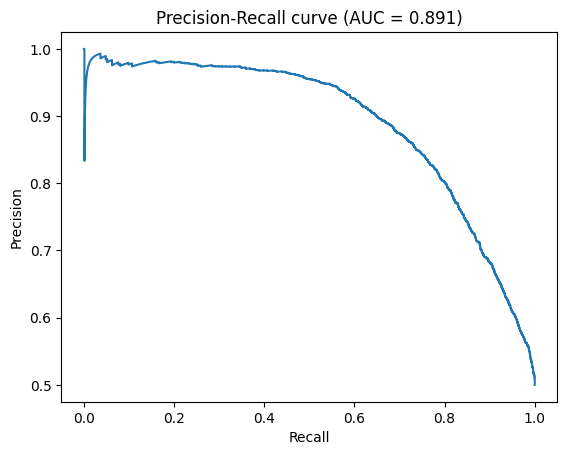

In [235]:
# --- PR-AUC Evaluation ---
pr_auc = average_precision_score(all_labels, all_preds)
print("PR-AUC:", pr_auc)

# Plot curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AUC = {pr_auc:.3f})")
plt.show()

## 11. Motif Visualization

Now that a prediction model is constructed, we can extract and visualize the sequence motifs that the model has learned in its first convolutional layer. Each filter in the CNN can be interpreted as a detector for short DNA patterns. To uncover these patterns, we scan a subset of sequences from the validation set, record the subsequences that produce the strongest activations for each filter, and average them to build a position weight matrix (PWM). These PWMs are then visualized as sequence logos, showing the nucleotide preferences at each position of the motif. By inspecting these logos, we can interpret what kinds of DNA motifs the network is recognizing, and potentially compare them to known transcription factor binding motifs.

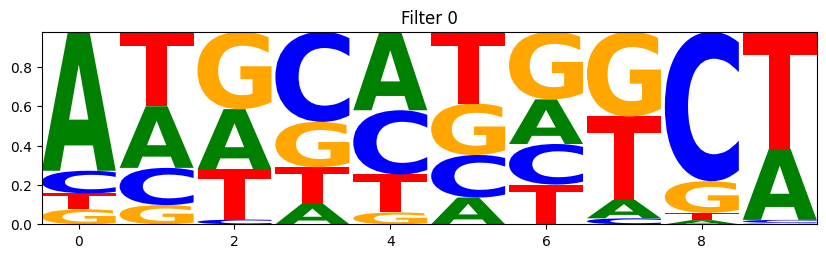

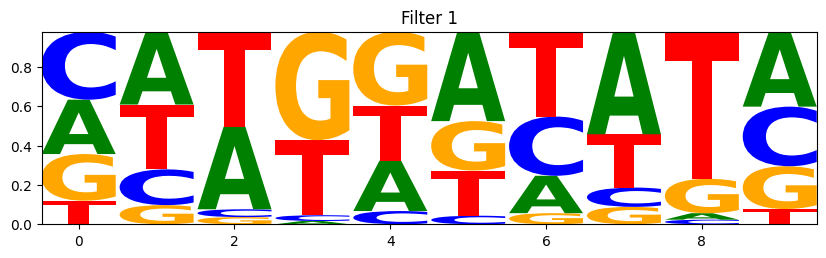

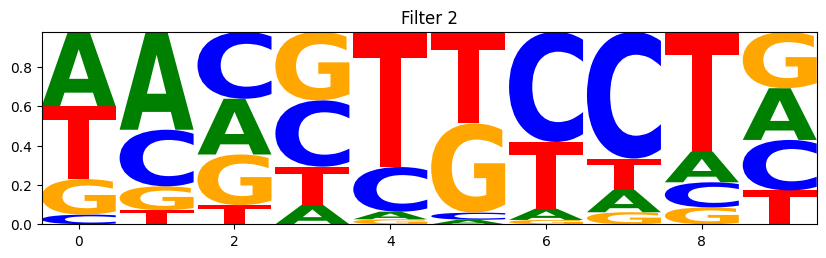

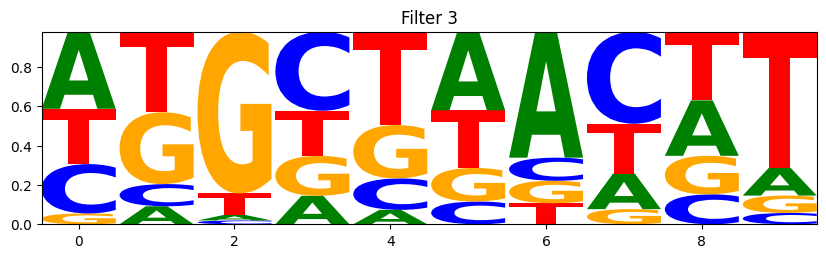

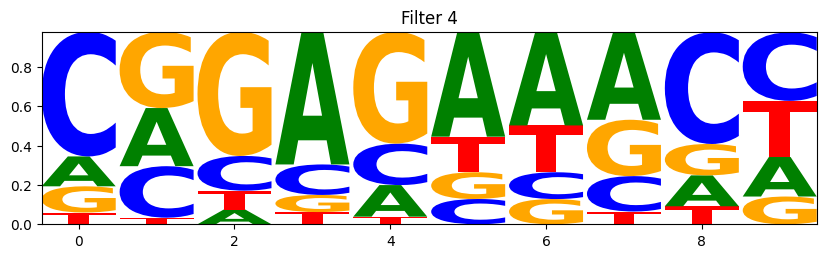

In [244]:
import logomaker

def get_filter_motifs(model, dataset, num_seqs=2000, top_k=200):
    """
    Extract subsequences that strongly activate filters in the first conv layer.
    Convert them into PWMs for motif visualization.
    """
    model.eval()
    conv_weights = model.conv1.weight.detach().cpu().numpy()  # shape (num_filters, 4, ksize)
    num_filters, _, ksize = conv_weights.shape

    # Collect subsequences
    subseqs = {i: [] for i in range(num_filters)}
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    with torch.no_grad():
        for b, (x, _) in enumerate(loader):
            if b * 64 > num_seqs:  # limit number of sequences
                break
            x = x.to(device)
            activations = model.conv1(x)  # (batch, filters, L_out)
            for f in range(num_filters):
                act = activations[:, f, :].cpu().numpy()
                for i in range(act.shape[0]):  # loop batch
                    # pick top activations
                    top_pos = np.argsort(act[i])[-top_k:]
                    seq = x[i].cpu().numpy().T  # shape (len, 4)
                    for pos in top_pos:
                        if pos + ksize <= seq.shape[0]:
                            window = seq[pos:pos+ksize]
                            subseqs[f].append(window)

    # Build PWMs
    motifs = {}
    for f in range(num_filters):
        if len(subseqs[f]) > 0:
            pwm = np.mean(np.stack(subseqs[f], axis=0), axis=0)  # average one-hot
            motifs[f] = pwm
    return motifs

# Extract motifs from the model using validation data
motifs = get_filter_motifs(model, val_ds, num_seqs=5000, top_k=5)

# Plot first 6 motifs as sequence logos
for i, pwm in list(motifs.items())[:5]:
    df = pd.DataFrame(pwm, columns=["A","C","G","T"])
    logo = logomaker.Logo(df, shade_below=.5, fade_below=.5,
                          color_scheme="classic")
    plt.title(f"Filter {i}")
    plt.show()